# Symmetrisierte Daten

Wenn man die Daten auf die ganze reziproke Gitterzelle fortsetzt, kann man das Gradient Descent auch ohne eingebaute Symmetrie verwenden. Dabei kommen deutlich bessere Modelle raus.

In [1]:
import setup
import numpy as np
from matplotlib import pyplot as plt
np.set_printoptions(precision=3, suppress=True)
from tight_binding_redweasel import *
from tight_binding_redweasel import qespresso_interface as qe
from tight_binding_redweasel import fermi_surface as fs

Symmetries: 48
[12.969+0.j 13.659+0.j 13.841+0.j 14.104+0.j 14.312+0.j 14.545+0.j
 15.913+0.j 16.374+0.j 17.331+0.j 17.566+0.j 18.055+0.j 23.452+0.j
 23.878+0.j 26.123+0.j 28.878+0.j 29.232+0.j]
loss: 1.37e-02 (max band-error [0.017 0.036 0.037 0.019 0.027 0.026 0.028 0.028 0.027 0.029 0.03  0.076
 0.336 0.961 1.435 1.199])


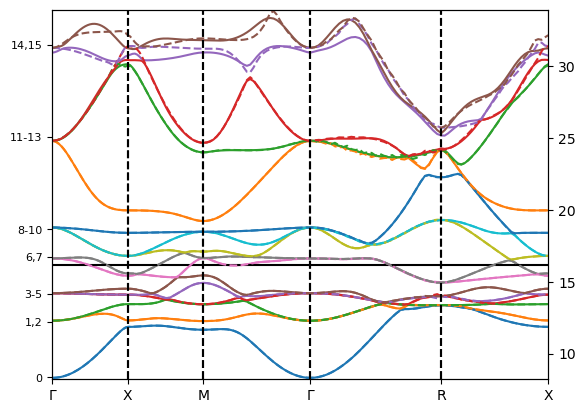

In [6]:
# read the data from Quantum Espresso
material = qe.from_disk("nitinol_2_993")
k_smpl, ref_bands, symmetries, fermi_energy = material.read_bands_crystal()
print("Symmetries:", len(symmetries))
ref_bands = ref_bands[:,8:]
k_smpl, ref_bands = Symmetry(symmetries).realize_symmetric_data(k_smpl, ref_bands)

# now start my algorithm to find good matrices
add_bands = 2
band_offset = 0 # = additional bands below reference

weights = np.ones(len(ref_bands[0]))
weights[0] = 0.5
weights[12:] = 0.01

neighbors = ((0, 0, 0), (1, 0, 0), (1, 1, 0), (1, 1, 1)) # works well
neighbors = Symmetry.cubic(True).complete_neighbors(neighbors)

#tb_nitinol = BandStructureModel.init_tight_binding_from_ref(Symmetry.none(), neighbors, k_smpl, ref_bands, band_offset, add_bands, cos_reduced=True, exp=True)
#tb_nitinol = BandStructureModel.load("ni_asym.repr")
tb_nitinol = BandStructureModel.load("asym_nitinol5.json")
#print(tb_nitinol.neighbors)
print(np.diag(tb_nitinol.params[0]))
#tb_nitinol.save("asym_nitinol2.json")
#tb_nitinol.optimize(k_smpl, 1, ref_bands, weights, band_offset, 100, 1, train_k0=True, max_accel_global=2.0)
#tb_nitinol.optimize(k_smpl, 1, ref_bands, weights, band_offset, 100, 1, train_k0=True, max_accel_global=8.0)
#tb_nitinol.optimize(k_smpl, 1, ref_bands, weights, band_offset, 100, 1, train_k0=True, max_accel_global=16.0)
#tb_nitinol.optimize(k_smpl, 1, ref_bands, weights, band_offset, 1000, 32, train_k0=True, regularization=0.999, learning_rate=1.0)

# show error
tb_nitinol.print_error(k_smpl, ref_bands, weights, band_offset)

interpolator = kpaths.interpolate(k_smpl, ref_bands, Symmetry.none(), method='cubic', periodic=False)
kpaths.SC_PATH.plot(tb_nitinol, '-')
kpaths.SC_PATH.plot(interpolator, '--', label_bands="left")
#plt.ylim(8, 24)
plt.axhline(fermi_energy, color="k")
plt.show()

16.17801589069899


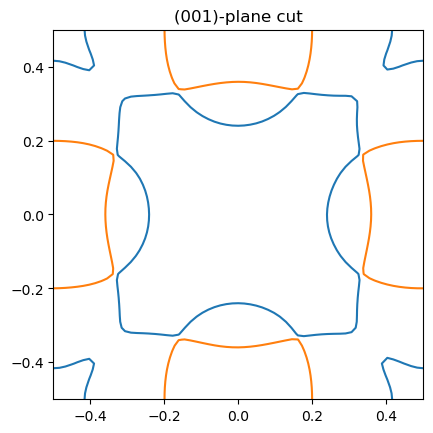

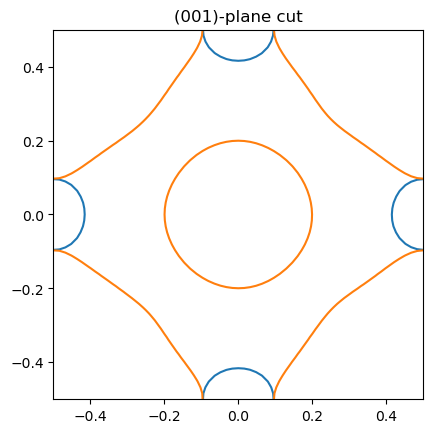

In [6]:
dos_nitinol = dos.DensityOfStates(tb_nitinol, N=20, ranges=((-0.5, 0.5),)*3, wrap=True)
fermi_energy = dos_nitinol.fermi_energy(7)
print(fermi_energy)

fs.plot_2D_fermi_surface(tb_nitinol, fermi_energy, N=63)

Symmetries: 48
k_points: 286
19 bands


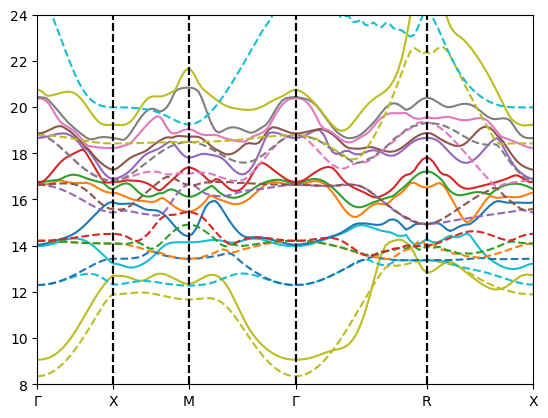

In [4]:
# read the data from Quantum Espresso
material = qe.from_disk("nitinol_0K")
k_smpl, ref_bands, symmetries, fermi_energy = material.read_bands_crystal()
print("Symmetries:", len(symmetries))
print("k_points:", len(k_smpl))
#k_smpl = -k_smpl
k_smpl, ref_bands = Symmetry(symmetries).realize_symmetric_data(np.round(k_smpl, 3), ref_bands)
#print(len(k_smpl))
# read wannier tight binding file
w_neighbors, w_params, w_r_params = material.read_wannier_tb()
#assert len(w_params[0]) == len(ref_bands[0])
print(len(w_params[0]), "bands")
#w_params[0] /= 2

wannier_tb_nitinol = BandStructureModel.init_tight_binding(Symmetry.none(), w_neighbors, len(w_params[0]), cos_reduced=False, exp=True)
wannier_tb_nitinol.set_params_complex(w_params)

interpolator = kpaths.interpolate(k_smpl, ref_bands, Symmetry.none(), method='cubic', periodic=False)
kpaths.SC_PATH.plot(wannier_tb_nitinol)
kpaths.SC_PATH.plot(interpolator, '--')
plt.ylim(8, 24)
plt.show()

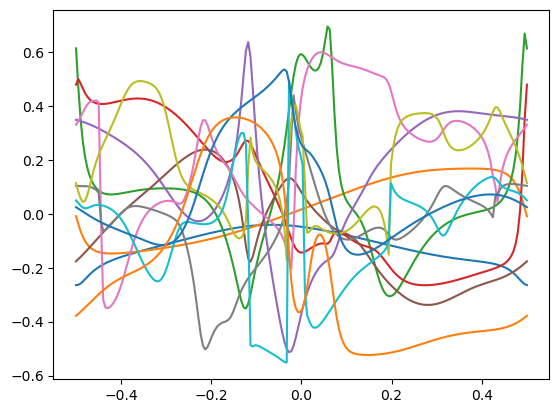

In [7]:
# plot how the unitary rotation matrices behave by plotting
# a few components of the matrices along a k-line
k_x = np.linspace(-0.5, 0.5, 200)
k_line = k_x[:,None] * np.array([[1, 0, 0]]) + np.array([[1, 1, 1]]) * 0.0
Uk = np.linalg.eigh(tb_nitinol.f(k_line))[1]
for i in range(6):
    plt.plot(k_x, np.abs(Uk[:,0,i]) * np.real(Uk[:,1,i] / Uk[:,0,i]))
    plt.plot(k_x, np.abs(Uk[:,0,i]) * np.real(Uk[:,2,i] / Uk[:,0,i]))
plt.show()

Symmetries: 48
(53, 16, 16)
loss: 1.10e-02 (max band-error [0.017 0.036 0.037 0.019 0.027 0.026 0.028 0.028 0.027 0.029 0.03  0.076
 0.336 0.961])


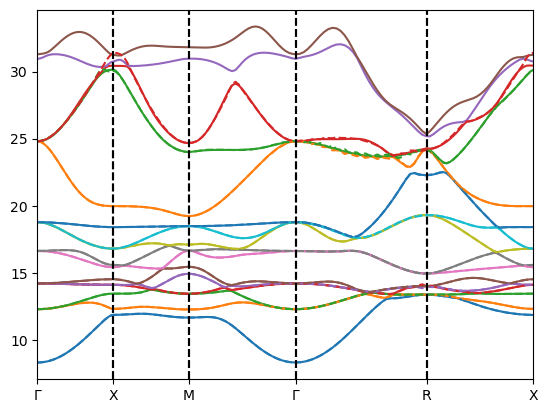

In [9]:
import setup
import numpy as np
from matplotlib import pyplot as plt
np.set_printoptions(precision=3, suppress=True)
from tight_binding_redweasel import *
from tight_binding_redweasel import qespresso_interface as qe
from tight_binding_redweasel import fermi_surface as fs

# read the data from Quantum Espresso
material = qe.from_disk("nitinol_2_993")
k_smpl, ref_bands, symmetries, fermi_energy = material.read_bands_crystal()
print("Symmetries:", len(symmetries))
ref_bands = ref_bands[:,8:-2]
k_smpl, ref_bands = Symmetry(symmetries).realize_symmetric_data(k_smpl, ref_bands)

band_offset = 0

weights = np.ones(len(ref_bands[0]))
weights[0] = 0.5 # lowest band can have less precision
weights[12:] = 0.01 # use 12 bands, use the rest just as "inspiration"

neighbors = ((0, 0, 0), (1, 0, 0), (1, 1, 0), (1, 1, 1))
neighbors = Symmetry.cubic(True).complete_neighbors(neighbors)

#tb_nitinol = AsymTightBindingModel.init_from_ref(neighbors, k_smpl, ref_bands)
tb_nitinol = AsymTightBindingModel.load("asym_nitinol5.json")
#tb_nitinol = AsymTightBindingModel.load("soft_sym_nitinol2.json")
print(tb_nitinol.H.H_r.shape)
#tb_nitinol = AsymTightBindingModel.load("bruinsma_improved.json")
#tb_nitinol.S = HermitianFourierSeries.unit_matrix(tb_nitinol.H.neighbors, len(tb_nitinol.H.H_r[0]))
# add a tiny bit of acceleration to break patterns that might occur
#tb_nitinol.optimize_cg(k_smpl, ref_bands, weights, band_offset, 100, train_S=False)
#tb_nitinol.optimize(k_smpl, 1, ref_bands, weights, band_offset, 100, 1, learning_rate=1.0, train_S=False, max_accel_global=1.0)
#tb_nitinol.optimize(k_smpl, 1, ref_bands, weights, band_offset, 100, 1, max_accel_global=16.0)
#tb_nitinol.optimize(k_smpl, 1, ref_bands, weights, band_offset, 100, 1, max_accel_global=64.0)
#tb_nitinol.optimize(k_smpl, 1, ref_bands, weights, band_offset, 1000, 32, regularization=0.999, learning_rate=1.0)

# show error
tb_nitinol.print_error(k_smpl, ref_bands, weights, band_offset)

path = kpaths.KPath('G').to('X').to('M').to('G').to('R').to('X')
interpolator = kpaths.interpolate(k_smpl, ref_bands, Symmetry.none(), method='cubic', periodic=False)
path.plot(tb_nitinol, '-')
path.plot(interpolator, '--')
#plt.ylim(8, 24)
plt.show()

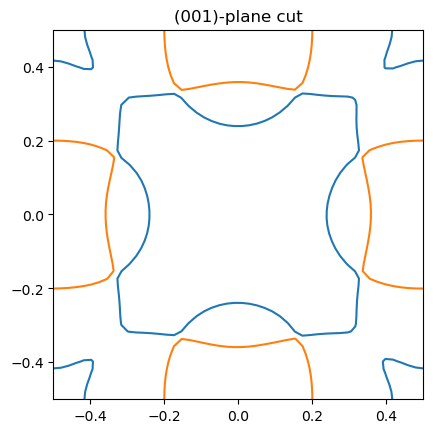

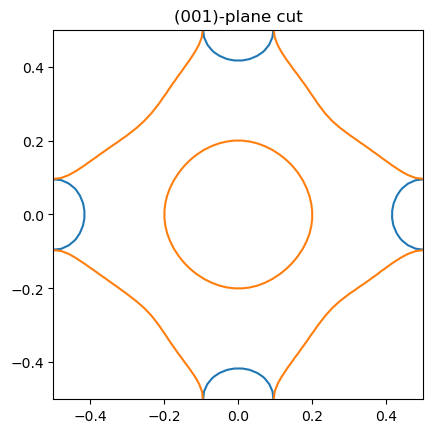

In [10]:
fs.plot_2D_fermi_surface(tb_nitinol, fermi_energy)